In [2]:
#Importaciones

#fundamentales
import pandas as pd

# Graficas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns 
from keras_visualizer import visualizer

# Modelado
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.models import Sequential

# #Config 
import warnings
warnings.filterwarnings('ignore')

2023-02-20 08:00:06.295193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Campos calculados y agrupaciones
path_to_save = 'oilfield'
df = pd.read_csv('oilfield.csv')
df.Fecha=pd.to_datetime(df.Fecha)

df['RGP'] = df['RGP'].astype(int) 
df['AYS'] = df['AYS'].astype(int) 
df['Elasticity'] = (df['Elasticity'] * 100).astype(int)
df['SP'] = (df['SP'] * 100).astype(int)
df['Fillage'] = (df['Fillage'] * 100).astype(int)

df['sand'] = pd.Series(dtype=int)
df['problem'] = pd.Series(dtype=int)
df['bnpd_group'] = pd.Series(dtype=int)
# df['bbpd_group'] = pd.Series(dtype=int)

df.loc[df['Prof']<7200,'sand'] = df.loc[df['Prof']<7200].fillna('A')
df.loc[df['Prof']>=7200,'sand'] = df.loc[df['Prof']>=7200].fillna('B')

df.loc[df['XCOORD']<160,'problem'] = df.loc[df['XCOORD']<160].fillna('Watter')
df.loc[df['XCOORD']>=160,'problem'] = df.loc[df['XCOORD']>=160].fillna('Gas')


df.loc[(df['BNPD']>=0)&(df['BNPD']<=100),'bnpd_group'] = df.loc[(df['BNPD']>=0)&(df['BNPD']<=100)].fillna('low')
df.loc[(df['BNPD']>=100)&(df['BNPD']<=200),'bnpd_group'] = df.loc[(df['BNPD']>=100)&(df['BNPD']<=200)].fillna('mid')
df.loc[df['BNPD']>=200,'bnpd_group'] = df.loc[df['BNPD']>=200].fillna('high')

df["BWPD"] = df["BBPD"] - df["BNPD"]

transform = pd.get_dummies(df['bnpd_group'])

df['low'] = transform['low']
df['mid'] = transform['mid']
df['high'] = transform['high']

print(df.info())

df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4494 entries, 0 to 4493
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   POZO            4494 non-null   object        
 1   XCOORD          4494 non-null   int64         
 2   YCOORD          4494 non-null   int64         
 3   Prof            4494 non-null   int64         
 4   Fecha           4494 non-null   datetime64[ns]
 5   runlife         4494 non-null   int64         
 6   ciclo           4494 non-null   int64         
 7   Dpiston         4494 non-null   float64       
 8   Lon_Superficie  4494 non-null   int64         
 9   SPM             4494 non-null   int64         
 10  RGP             4494 non-null   int64         
 11  AYS             4494 non-null   int64         
 12  Elasticity      4494 non-null   int64         
 13  SP              4494 non-null   int64         
 14  Fillage         4494 non-null   int64         
 15  BBPD

,POZO,XCOORD,YCOORD,Prof,Fecha,runlife,ciclo,Dpiston,Lon_Superficie,SPM,...,Fillage,BBPD,BNPD,sand,problem,bnpd_group,BWPD,low,mid,high
3996,BN-0057,211,233,7165,2019-11-20,679,0,2.000,100,4,...,43,141.216718,119.753762,A,Gas,mid,21.462955,0,1,0
4196,BN-0082,218,199,7190,2019-12-06,388,5,1.125,74,4,...,54,33.484559,26.890332,A,Gas,low,6.594226,1,0,0
2094,BN-0090,125,293,7198,2019-06-20,437,6,1.125,120,4,...,60,56.395052,30.411526,A,Watter,low,25.983526,1,0,0
1965,BN-0097,87,113,7205,2019-06-09,521,6,1.125,120,7,...,63,103.206161,59.120382,B,Watter,low,44.085779,1,0,0
1419,BN-0090,125,293,7198,2019-04-26,382,6,1.125,120,4,...,64,62.243154,34.236450,A,Watter,low,28.006703,1,0,0


In [4]:
#Funcion de calculo
def test_network(model,filename,X,y,X_pred,test_size=0.2,optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    _ = model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
    _ = model.fit(X_train, y_train, batch_size=10, epochs=100, verbose=0)
    scores_train = model.evaluate(X_train, y_train,verbose=0)
    scores_test = model.evaluate(X_test, y_test,verbose=0)
    path = path_to_save+'/'+filename
    _= visualizer(model, format='png', filename=path)

    X_pred_scaled = preprocessing.scale(X_pred)
    X_pred_scaled = pd.DataFrame(X_pred_scaled, columns=X_pred.columns)
    X_pred = X_pred_scaled
    predictions = model.predict(X_pred, verbose=0)

    return scores_train,scores_test,predictions 

In [5]:
#Preparacion de la data
columnsToDrop = ['POZO','Fecha','AYS','BWPD','BBPD','BNPD','bnpd_group','sand','problem']
dfg = df.drop(columns=columnsToDrop)
dfg = preprocessing.scale(dfg)
dfg = pd.DataFrame(dfg, columns=df.columns.drop(columnsToDrop))
dfg['low'] = df['low'] #se regresa el bnpd_group al varlo original
dfg['mid'] = df['mid'] #se regresa el bnpd_group al varlo original
dfg['high'] = df['high'] #se regresa el bnpd_group al varlo original

dgsp = dfg.sample(frac=0.03, random_state=200) #un set adicional para predecir adicional
dfg = dfg.drop(dgsp.index) # dataset de entrenamiento

# Xg = dfg.drop(columns=['low','mid','high'])
Xg = dfg[['XCOORD', 'YCOORD', 'Prof','Dpiston']]
yg = dfg[['low','mid','high']]

# Xg_pred = dfg.drop(columns=['low','mid','high'])
Xg_pred = dgsp[['XCOORD', 'YCOORD', 'Prof','Dpiston']]
yg_pred = dgsp[['low','mid','high']]

print(dfg.shape)
print(dgsp.shape)
dfg.sample(5)

(4359, 15)
(135, 15)


,XCOORD,YCOORD,Prof,runlife,ciclo,Dpiston,Lon_Superficie,SPM,RGP,Elasticity,SP,Fillage,low,mid,high
2727,-0.470318,0.316210,1.220003,-0.847379,-0.506430,0.473626,1.343342,0.107598,0.427407,0.187134,1.370081,0.035630,0,1,0
3910,1.161507,0.135876,-0.277633,0.685054,-0.506430,-1.205360,1.343342,-0.549395,-0.151962,-0.290243,1.170336,0.819469,1,0,0
4320,-1.033016,-1.195824,-0.415031,0.529213,0.902213,-1.205360,-0.282656,-1.206387,-1.661371,1.619263,0.037021,1.864588,1,0,0
1228,1.175575,0.385569,-0.387551,-0.639592,-0.975978,0.473626,-0.989612,1.421584,-0.902093,-0.290243,-0.989135,-0.661116,0,1,0
2254,-0.948611,0.343954,-0.153975,-0.808419,1.841308,0.473626,1.343342,1.421584,-0.636803,1.141886,1.676984,0.645283,0,1,0


In [6]:
# Configuracion del mallado 
list_models_test = [
    {
        'Descripcion' : '1 capa de entrada con 4 nodos, 2 capas ocultas de 6 nodos y 1 capa de salidad con 3 nodo',
        'model':Sequential([
            Dense(6,activation='relu',input_dim=len(Xg.columns)),
            Dense(6,activation='relu'),
            Dense(3,activation='softmax')
        ])
    },
        {
        'Descripcion' : '1 capa de entrada con 4 nodos, 3 capas ocultas de 6 nodos y 1 capa de salidad con 3 nodo',
        'model':Sequential([
            Dense(6,activation='relu',input_dim=len(Xg.columns)),
            Dense(6,activation='relu'),
            Dense(6,activation='relu'),
            Dense(3,activation='softmax')
        ])
    },
    {
        'Descripcion' : '1 capa de entrada con 4 nodos, 3 capas ocultas de 12 nodos y 1 capa de salidad con 3 nodo',
        'model':Sequential([
            Dense(12,activation='relu',input_dim=len(Xg.columns)),
            Dense(12,activation='relu'),
            Dense(12,activation='relu'),
            Dense(3,activation='softmax')
        ])
    },
    {
        'Descripcion' : '1 capa de entrada con 4 nodos, 4 capas ocultas de 12 nodos y 1 capa de salidad con 3 nodo',
        'model':Sequential([
            Dense(12,activation='relu',input_dim=len(Xg.columns)),
            Dense(12,activation='relu'),
            Dense(12,activation='relu'),
            Dense(12,activation='relu'),
            Dense(3,activation='softmax')
        ])
    },
    {
        'Descripcion' : '1 capa de entrada con 4 nodos, 4 capas ocultas 1 de 12 y 3 de 24 nodos y 1 capa de salidad con 3 nodo',
        'model':Sequential([
            Dense(12,activation='relu',input_dim=len(Xg.columns)),
            Dense(24,activation='relu'),
            Dense(24,activation='relu'),
            Dense(24,activation='relu'),
            Dense(3,activation='softmax')
        ])
    },
    {
        'Descripcion' : '1 capa de entrada con 4 nodos, 5 capas ocultas de 32 nodos y 1 capa de salidad con 3 nodo',
        'model':Sequential([
            Dense(32,activation='relu',input_dim=len(Xg.columns)),
            Dense(32,activation='relu'),
            Dense(32,activation='relu'),
            Dense(32,activation='relu'),
            Dense(32,activation='relu'),
            Dense(3,activation='softmax')
        ])
    },
]

2023-02-20 08:02:04.851817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


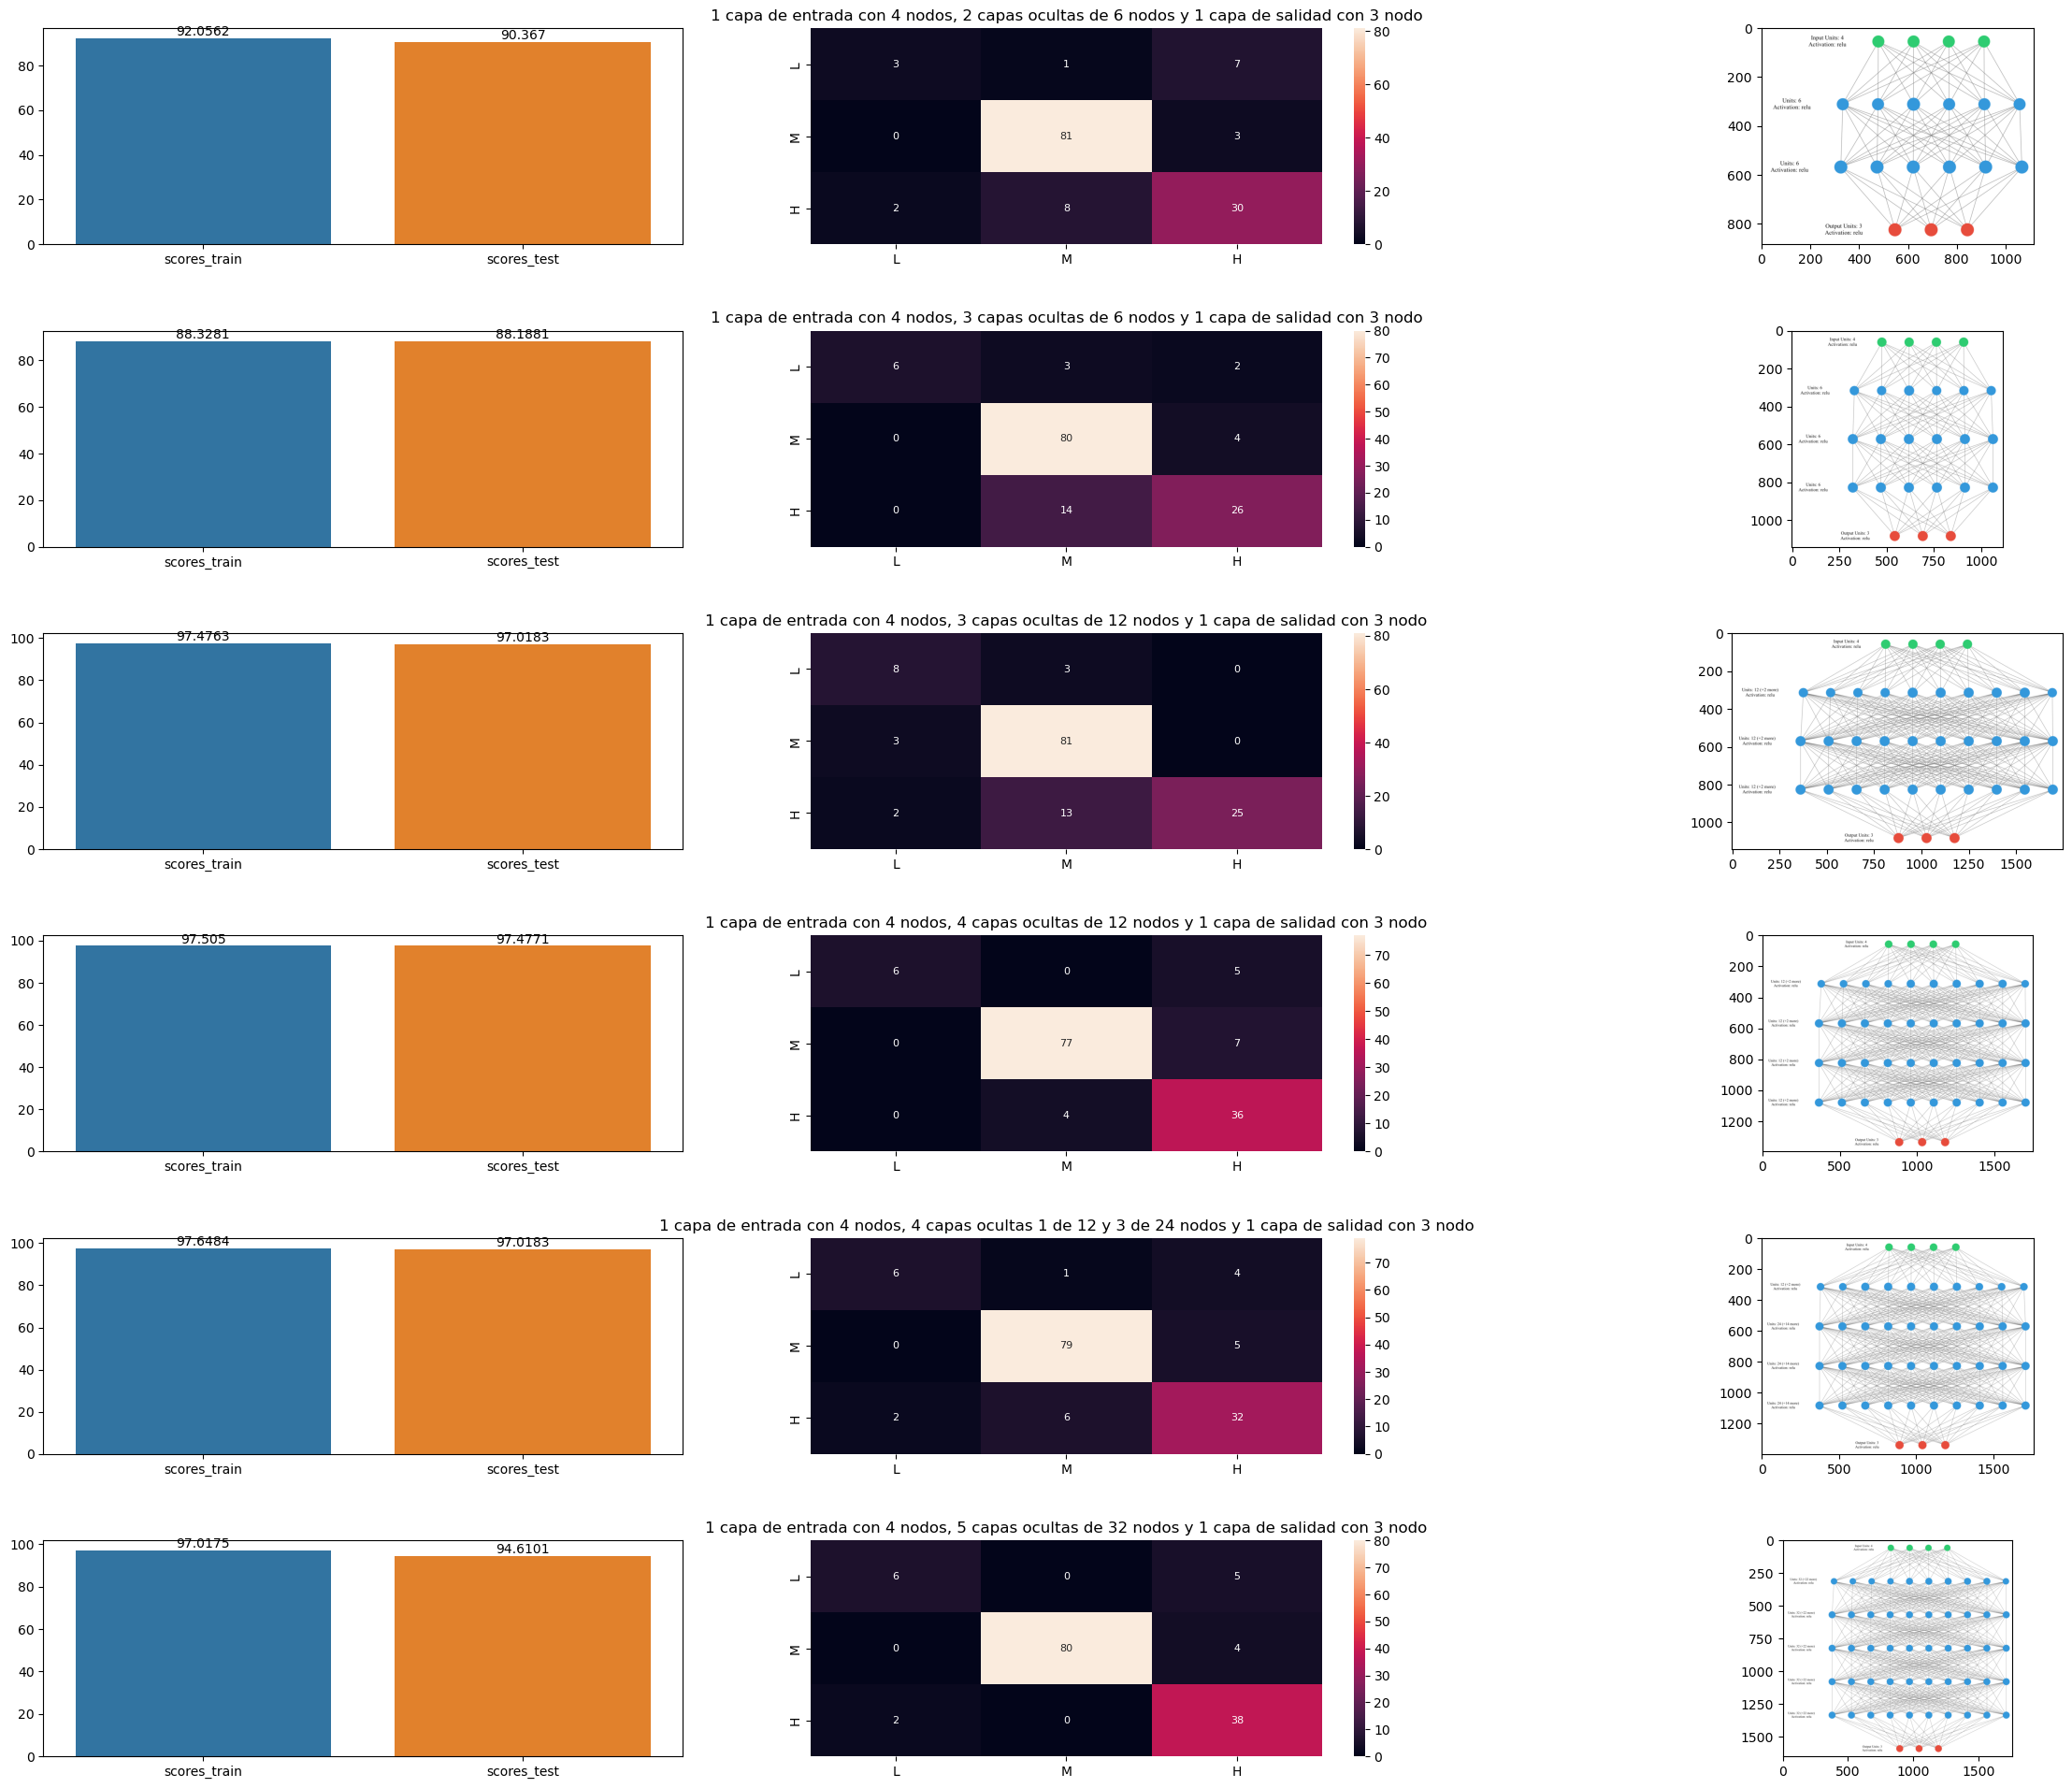

In [7]:
#modelado
fig, axes = plt.subplots(len(list_models_test), 3,figsize=(30,len(list_models_test)*4))
fig.subplots_adjust(hspace=0.4)

for i,m in enumerate(list_models_test):
    train,test,predictions = test_network(m['model'],str(i),Xg,yg,Xg_pred)
    test_pred=predictions
    _=axes[i,1].set_title(m['Descripcion'])
    ab = sns.barplot(ax=axes[i,0],data=pd.DataFrame([{'scores_train':train[1]*100,'scores_test':test[1]*100}],columns=['scores_train','scores_test']))
    ab.bar_label(ab.containers[0])
    predicted_df = pd.DataFrame(predictions, columns=['low','mid','high'])
    cm = confusion_matrix(yg_pred.idxmax(axis=1), predicted_df.idxmax(axis=1))
    _= sns.heatmap(ax=axes[i,1],data=cm,annot=True, xticklabels=['L','M','H'],yticklabels=['L','M','H'],annot_kws={"size": 8})
    imgpath = path_to_save+'/'+str(i) + '.png'
    img = mpimg.imread(imgpath)
    _= axes[i,2].imshow(img)
